In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv2DTranspose
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import torch
from tensorflow.keras.applications import InceptionV3, VGG16

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define the data transformation to apply to the images
h, w = (830, 500)
data_transform = transforms.Compose([
    transforms.Resize((h, w)),  # Resize the image to (224, 224)
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(           # Normalize the image channels
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the dataset using ImageFolder
data_dir = 'dataset_images/'
dataset = datasets.ImageFolder(root=data_dir, transform=data_transform)

# Create a DataLoader to handle batching and shuffling of data
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


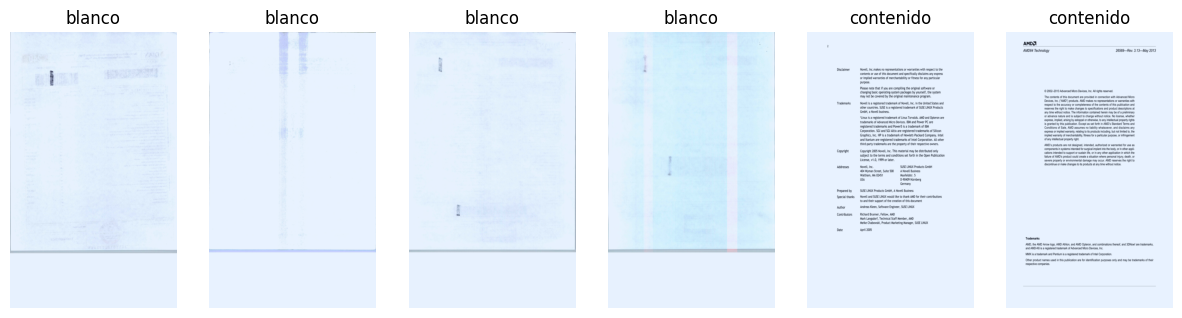

In [5]:
# Get a batch of images and their corresponding labels from the DataLoader
images, labels = next(iter(data_loader))
denormalized_images = (images * 0.225) + 0.406

# Plot the images
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    image = denormalized_images[i].permute(1, 2, 0)  # Convert the tensor back to (H, W, C) format
    label = dataset.classes[labels[i]]  # Get the class label

    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

In [6]:
# Split the dataset into training, validation, and testing sets
train_size = int(0.8 * len(dataset))        # Use 80% of the data for training
val_size = int(0.1 * len(dataset))          # Use 10% of the data for validation
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for training, validation, and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Convert PyTorch tensors to numpy arrays
def torch_to_numpy(loader):
    all_data = []
    all_labels = []
    for data, labels in loader:
        all_data.append(data.numpy())
        all_labels.append(labels.numpy())
    return np.concatenate(all_data), np.concatenate(all_labels)

X_train, y_train = torch_to_numpy(train_loader)
X_val, y_val = torch_to_numpy(val_loader)
X_test, y_test = torch_to_numpy(test_loader)

X_train = np.transpose(X_train, (0, 2, 3, 1))
X_val = np.transpose(X_val, (0, 2, 3, 1))
X_test = np.transpose(X_test, (0, 2, 3, 1))

In [7]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet", 
    input_shape=(h, w, 3),
)

In [8]:
base_model.trainable = False
output_bm = base_model.output
flatten = Flatten()(output_bm)

In [9]:
output_shape = len(dataset.classes)
class_layer = GlobalAveragePooling2D()(output_bm)
class_layer = Dense(512, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
class_layer = Dense(256, activation = "relu")(class_layer)
class_layer = Dropout(0.1)(class_layer)
output_class = Dense(output_shape, activation ="sigmoid", name ='label')(class_layer)

In [10]:
pretrained_inceptionV3_model = Model(inputs=base_model.input, outputs=[output_class])

In [11]:
pretrained_inceptionV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 830, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 414, 249, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 414, 249, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
lr = 1e-3
optimizer = Adam(learning_rate=lr)

In [13]:
pretrained_inceptionV3_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = [early_stopping]

In [16]:
pretrained_inceptionV3_model_history = pretrained_inceptionV3_model.fit(X_train,
                                                                        y_train,
                                                                        epochs=200,
                                                                        validation_data = (X_val,
                                                                                           y_val),
                                                                        callbacks=callbacks
                                                                       )

Epoch 1/200
7/7 [==============================] - 29s 2s/step - loss: 0.3703 - accuracy: 0.8122 - val_loss: 0.1206 - val_accuracy: 0.9167
Epoch 2/200
7/7 [==============================] - 5s 666ms/step - loss: 0.1570 - accuracy: 0.9239 - val_loss: 0.0377 - val_accuracy: 1.0000
Epoch 3/200
7/7 [==============================] - 5s 666ms/step - loss: 0.0419 - accuracy: 0.9848 - val_loss: 0.0564 - val_accuracy: 1.0000
Epoch 4/200
7/7 [==============================] - 5s 663ms/step - loss: 0.0224 - accuracy: 0.9949 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 5/200
7/7 [==============================] - 5s 670ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 6/200
7/7 [==============================] - 5s 685ms/step - loss: 0.0480 - accuracy: 0.9898 - val_loss: 0.0408 - val_accuracy: 0.9583
Epoch 7/200
7/7 [==============================] - 5s 684ms/step - loss: 0.0552 - accuracy: 0.9797 - val_loss: 0.5374 - val_accuracy: 0.7500
Epoch 8/200
7/7

In [17]:
pretrained_inceptionV3_val = pretrained_inceptionV3_model.evaluate(X_val, y_val)
print('Validation loss: {:4f}\nValidation Accuracy: {:4f}'.format(pretrained_inceptionV3_val[0], pretrained_inceptionV3_val[1]))

1/1 [==============================] - 1s 591ms/step - loss: 0.0111 - accuracy: 1.0000
Validation loss: 0.011075
Validation Accuracy: 1.000000


In [18]:
pretrained_inceptionV3_test = pretrained_inceptionV3_model.evaluate(X_test, y_test)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(pretrained_inceptionV3_test[0], pretrained_inceptionV3_test[1]))

1/1 [==============================] - 4s 4s/step - loss: 0.0822 - accuracy: 0.9615
Test loss: 0.082161
Test Accuracy: 0.961538


In [19]:
pretrained_inceptionV3_predicted = pretrained_inceptionV3_model.predict(X_test).argmax(axis=1)
print('Reporte para el modelo construido')
print(classification_report(y_test, pretrained_inceptionV3_predicted))

1/1 [==============================] - 3s 3s/step
Reporte para el modelo construido
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.90      0.95        10

    accuracy                           0.96        26
   macro avg       0.97      0.95      0.96        26
weighted avg       0.96      0.96      0.96        26

